In [1]:
import os
import re
import docx2txt
from pdfminer.high_level import extract_text
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

C:\Users\DHRUV GUPTA\AppData\Roaming\Python\Python312\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
C:\Users\DHRUV GUPTA\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Load pre-trained model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Utils
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def extract_text_from_file(file_path):
    if file_path.endswith(".pdf"):
        return extract_text(file_path)
    elif file_path.endswith(".docx"):
        return docx2txt.process(file_path)
    else:
        return ""

def load_resumes(folder_path):
    resumes = {}
    for file in os.listdir(folder_path):
        if file.endswith((".pdf", ".docx")):
            full_path = os.path.join(folder_path, file)
            raw_text = extract_text_from_file(full_path)
            cleaned_text = clean_text(raw_text)
            resumes[file] = {
                "raw_text": raw_text,
                "cleaned_text": cleaned_text
            }
            return resumes
    return resumes

def load_job_description(jd_path):
    with open(jd_path, "r", encoding="utf-8") as f:
        text = f.read()
    return clean_text(text)

# def compute_similarity(resumes_dict, jd_text):
#     jd_embedding = model.encode([jd_text])[0]
#     # print("JD Embedding (first 10 dims):", jd_embedding[:])

#     result = {}

#     for filename, resume_text in resumes_dict.items():
#         resume_embedding = model.encode([resume_text])[0]
#         # print(f"{filename} Embedding (first 10 dims):", resume_embedding[:10])  
#         similarity = cosine_similarity([jd_embedding], [resume_embedding])[0][0]
#         result[filename] = round(similarity * 100, 2)

#     return dict(sorted(result.items(), key=lambda x: x[1], reverse=True))
def compute_similarity(resumes_dict, jd_text):
    jd_embedding = model.encode([jd_text])[0]
    result = {}

    for filename, data in resumes_dict.items():
        cleaned_text = data["cleaned_text"]
        resume_embedding = model.encode([cleaned_text])[0]
        similarity = cosine_similarity([jd_embedding], [resume_embedding])[0][0]
        result[filename] = round(similarity * 100, 2)

    return dict(sorted(result.items(), key=lambda x: x[1], reverse=True))


In [8]:
# # Run
# resumes = load_resumes("resumes/")
# jd_text = load_job_description("job_description.txt")
# scores = compute_similarity(resumes, jd_text)

# print("\nResume Screening Results (using Transformers):\n")
# for name, score in scores.items():
#     print(f"{name}: {score}% match")
# Run
resumes = load_resumes("resumes/")
jd_text = load_job_description("job_description.txt")
scores = compute_similarity(resumes, jd_text)

print("\nResume Screening Results (using Transformers):\n")
for name, score in scores.items():
    print(f"{name}: {score}% match")

# Display raw text for one resume (first in the list)
print("\n\nExtracted Raw Text from One Resume:\n")
first_resume = next(iter(resumes.items()))  # get first resume entry
file_name, data = first_resume
print(f"Filename: {file_name}")
print("Raw Text:\n")
print(data["raw_text"])

print("\nCleaned Text:\n")
print(data["cleaned_text"])



Resume Screening Results (using Transformers):

12011623.pdf: 72.2% match
27040860.pdf: 59.38% match
26456899.pdf: 52.94% match
51588273.pdf: 52.81% match
19396040.pdf: 52.0% match
37335325.pdf: 51.61% match
12518008.pdf: 51.28% match
82246962.pdf: 50.66% match
28628090.pdf: 50.38% match
30097175.pdf: 49.8% match
32985311.pdf: 49.14% match
11890896.pdf: 48.87% match
19553067.pdf: 48.69% match
38314236.pdf: 48.58% match
12472574.pdf: 48.43% match
28630325.pdf: 48.24% match
24322804.pdf: 47.7% match
47919212.pdf: 47.22% match
61579998.pdf: 46.66% match
22605864.pdf: 46.56% match
21038022.pdf: 46.34% match
10030015.pdf: 46.26% match
25919149.pdf: 45.09% match
25608963.pdf: 44.79% match
21847415.pdf: 44.35% match
35389360.pdf: 44.32% match
81125166.pdf: 43.99% match
55595908.pdf: 43.88% match
27152464.pdf: 43.36% match
23234047.pdf: 43.26% match
16803215.pdf: 43.24% match
90280583.pdf: 43.24% match
36149549.pdf: 43.08% match
17926546.pdf: 43.07% match
19612167.pdf: 42.97% match
23438227.p

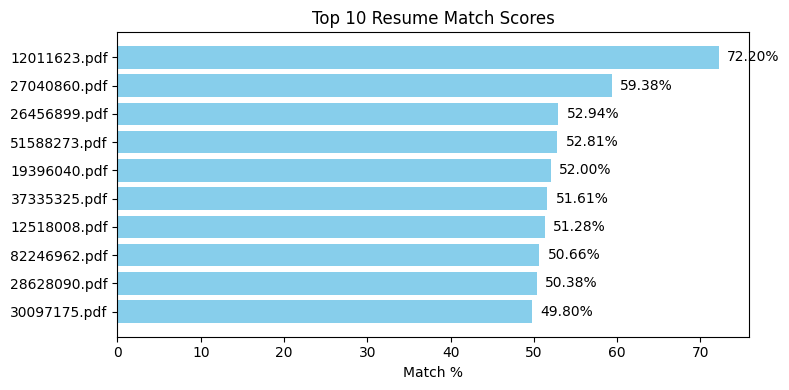

In [4]:
# Plotting only top 10 resumes
import matplotlib.pyplot as plt
import pandas as pd
import tempfile
import os

# Take only top 10 scores
top_scores = dict(list(scores.items())[:10])
df = pd.DataFrame(list(top_scores.items()), columns=["Resume", "Match %"])

plt.figure(figsize=(8, 4))
bars = plt.barh(df["Resume"], df["Match %"], color="skyblue")
plt.xlabel("Match %")
plt.title("Top 10 Resume Match Scores")
plt.gca().invert_yaxis()

for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height() / 2, f'{width:.2f}%', va='center')

plot_path = os.path.join(tempfile.gettempdir(), "match_plot.png")
plt.tight_layout()
plt.savefig(plot_path)
plt.show()